# 3-b: Bayesian Linear Regression

During this session, we will work with Bayesian Linear Regression models with varying basis functions (linear, polynomial and Gaussian). Datasets used are 1D toy regression samples ranging from linear datasets to more complex non-linear datasets such as increasing sinusoidal curves.

**Goal**: Take hand on simple Bayesian models, understand how it works, gain finer insights on predictive distribution.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#@title Useful functions
def plot_results(X_train, y_train, X_test, y_test, y_pred, std_pred,
                 xmin=-2, xmax=2, ymin=-2, ymax=1, stdmin=0.30, stdmax=0.45):
    """Given a dataset and predictions on test set, this function draw 2 subplots:
    - left plot compares train set, ground-truth (test set) and predictions
    - right plot represents the predictive variance over input range

    Args:
      X_train: (array) train inputs, sized [N,]
      y_train: (array) train labels, sized [N, ]
      X_test: (array) test inputs, sized [N,]
      y_test: (array) test labels, sized [N, ]
      y_pred: (array) mean prediction, sized [N, ]
      std_pred: (array) std prediction, sized [N, ]
      xmin: (float) min value for x-axis on left and right plot
      xmax: (float) max value for x-axis on left and right plot
      ymin: (float) min value for y-axis on left plot
      ymax: (float) max value for y-axis on left plot
      stdmin: (float) min value for y-axis on right plot
      stdmax: (float) max value for y-axis on right plot

    Returns:
      None
    """
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.xlim(xmin = xmin, xmax = xmax)
    plt.ylim(ymin = ymin, ymax = ymax)
    plt.plot(X_test, y_test, color='green', linewidth=2,
             label="Ground Truth")
    plt.plot(X_train, y_train, 'o', color='blue', label='Training points')
    plt.plot(X_test, y_pred, color='red', label="BLR Poly")
    plt.fill_between(X_test, y_pred-std_pred, y_pred+std_pred, color='indianred', label='1 std. int.')
    plt.fill_between(X_test, y_pred-std_pred*2, y_pred-std_pred, color='lightcoral')
    plt.fill_between(X_test, y_pred+std_pred*1, y_pred+std_pred*2, color='lightcoral', label='2 std. int.')
    plt.fill_between(X_test, y_pred-std_pred*3, y_pred-std_pred*2, color='mistyrose')
    plt.fill_between(X_test, y_pred+std_pred*2, y_pred+std_pred*3, color='mistyrose', label='3 std. int.')
    plt.legend()

    plt.subplot(122)
    plt.title("Predictive variance along x-axis")
    plt.xlim(xmin = xmin, xmax = xmax)
    plt.ylim(ymin = stdmin, ymax = stdmax)
    plt.plot(X_test, std_pred**2, color='red', label="\u03C3² {}".format("Pred"))

    # Get training domain
    training_domain = []
    current_min = sorted(X_train)[0]
    for i, elem in enumerate(sorted(X_train)):
        if elem-sorted(X_train)[i-1]>1:
            training_domain.append([current_min,sorted(X_train)[i-1]])
            current_min = elem
    training_domain.append([current_min, sorted(X_train)[-1]])

    # Plot domain
    for j, (min_domain, max_domain) in enumerate(training_domain):
        plt.axvspan(min_domain, max_domain, alpha=0.5, color='gray', label="Training area" if j==0 else '')
    plt.axvline(X_train.mean(), linestyle='--', label="Training barycentre")

    plt.legend()
    plt.show()




## Part I: Linear Basis function model

We start with a linear dataset where we will analyze the behavior of linear basis functions in the framework of Bayesian Linear Regression.

In [ ]:
# Generate linear toy dataset
def f_linear(x, noise_amount, sigma):
    y = -0.3 + 0.5*x
    noise = np.random.normal(0, sigma, len(x))
    return y + noise_amount*noise

# Create training and test points
sigma = 0.2
nbpts=25
dataset_linear = {}
dataset_linear['X_train'] = np.random.uniform(0, 2, nbpts)
dataset_linear['y_train'] = f_linear(dataset_linear['X_train'], noise_amount=1, sigma=sigma)
dataset_linear['X_test'] = np.linspace(-10,10, 10*nbpts)
dataset_linear['y_test'] = f_linear(dataset_linear['X_test'], noise_amount=0, sigma=sigma)

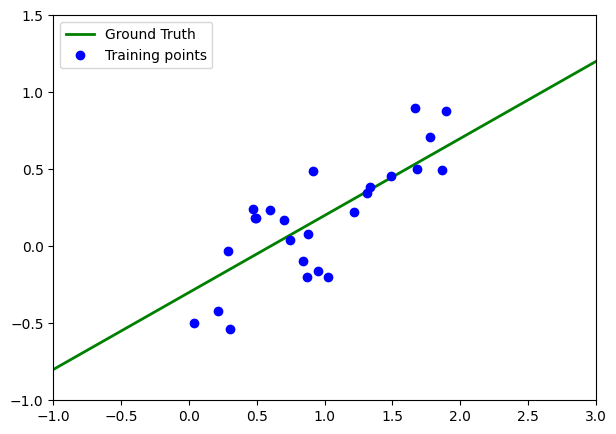

In [ ]:
# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmax = 3, xmin =-1)
plt.ylim(ymax = 1.5, ymin = -1)
plt.plot(dataset_linear['X_test'], dataset_linear['y_test'], color='green', linewidth=2, label="Ground Truth")
plt.plot(dataset_linear['X_train'], dataset_linear['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

In [ ]:
# Hyperparameters
dataset_linear['ALPHA'] = 2.0
dataset_linear['BETA'] = 1/(2.0*sigma**2)

We will use the linear basis function:
    $\phi:x \rightarrow (1,x)$

Design matrix $\Phi$ defined on training set is:
$$ \Phi=
  \begin{bmatrix}
    1 & x_1 \\
    ... & ...\\
    1 & x_n
  \end{bmatrix}
$$

# **Question 1.1: Code linear basis function**

In [ ]:
#TO DO: Define basis function

def phi_linear(x):
    """ Linear Basis Functions

    Args:
      x: (float) 1D input

    Returns:
      (array) linear features of x
    """
    # TO DO
    return np.array([1, x])

# **Question 1.2: Recall closed form of the posterior distribution in linear case. Then, code and visualize posterior sampling. What can you observe?**

# **Answer:**

In Bayesian Linear Regression, given the likelihood $p(y|\mathbf{x}, \mathbf{w}, \beta) = \mathcal{N}(y | \mathbf{w}^T \phi(\mathbf{x}), \beta^{-1})$ and the prior $p(\mathbf{w}) = \mathcal{N}(\mathbf{w} | \mathbf{m}_0, \mathbf{S}_0)$, the posterior distribution $p(\mathbf{w}|\mathbf{y})$ is also Gaussian $\mathcal{N}(\mathbf{w} | \mathbf{m}_N, \mathbf{S}_N)$ where:

$\mathbf{S}_N^{-1} = \mathbf{S}_0^{-1} + \beta \Phi^T \Phi$
$\mathbf{m}_N = \mathbf{S}_N (\mathbf{S}_0^{-1} \mathbf{m}_0 + \beta \Phi^T \mathbf{y})$
With $\mathbf{m}_0 = \mathbf{0}$ and $\mathbf{S}_0 = \alpha^{-1} \mathbf{I}$, this simplifies to:

$\mathbf{S}_N^{-1} = \alpha \mathbf{I} + \beta \Phi^T \Phi$
$\mathbf{m}_N = \beta \mathbf{S}_N \Phi^T \mathbf{y}$


# **Observation:** As we observe more data points, the posterior distribution becomes more "concentrated" around the true parameters. Sampling from the posterior allows us to see the range of plausible linear models that explain the observed data.

/tmp/ipython-input-537908282.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  posterior[i,j] = np.exp(-0.5* np.dot(np.dot((w-mu_N.reshape(2,1)).T, np.linalg.inv(sigma_N)) , (w-mu_N.reshape(2,1)) ) )


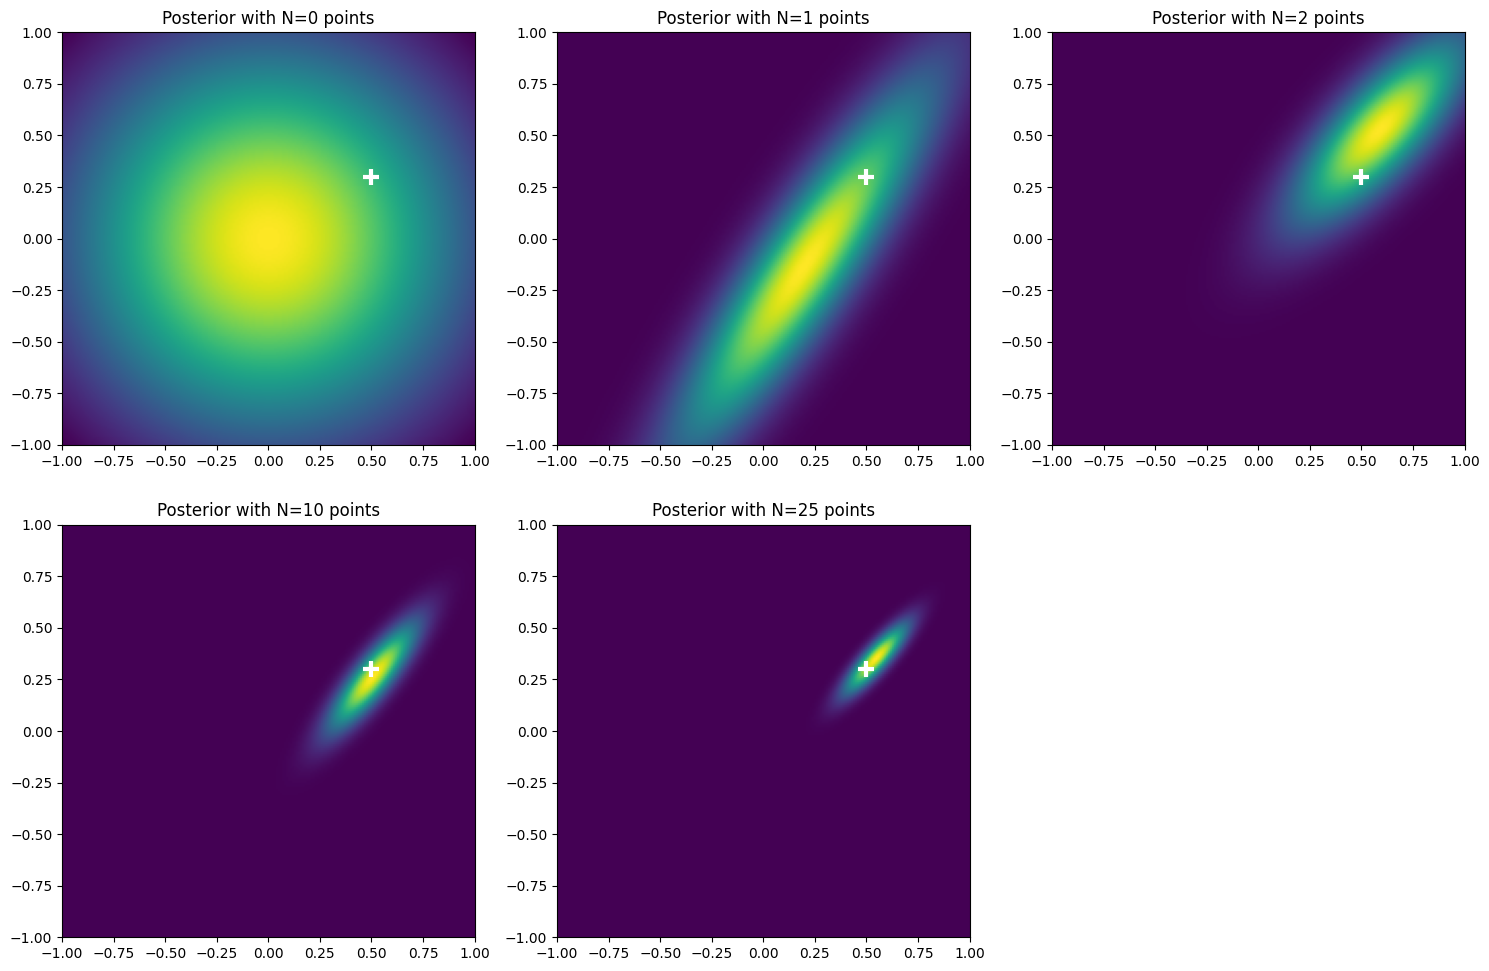

In [ ]:
#TO DO: Code and visualize posterior sampling by completing code below
plt.figure(figsize=(15,10))
for count,n in enumerate([0,1,2,10,len(dataset_linear['X_train'])]):
    cur_data = dataset_linear['X_train'][:n]
    cur_lbl = dataset_linear['y_train'][:n]
    meshgrid = np.arange(-1, 1.01, 0.01)
    w = np.zeros((2,1))
    posterior = np.zeros((meshgrid.shape[0],meshgrid.shape[0]))

    # TO DO: code mu_n and sigma_N
    # Inside the loop, replace the "# TO DO: code mu_n and sigma_N" with:
    if n == 0:
        # Prior: N(0, (1/alpha)*I)
        sigma_N = (1.0 / dataset_linear['ALPHA']) * np.eye(2)
        mu_N = np.zeros(2)
    else:
        # Compute design matrix Phi
        Phi = np.array([phi_linear(xi) for xi in cur_data])  # Shape: (n, 2)
        # Posterior covariance
        sigma_N = np.linalg.inv(dataset_linear['ALPHA'] * np.eye(2) + dataset_linear['BETA'] * Phi.T @ Phi)
        # Posterior mean
        mu_N = dataset_linear['BETA'] * sigma_N @ Phi.T @ cur_lbl

    # Compute values on meshgrid
    for i in range(meshgrid.shape[0]):
        for j in range(meshgrid.shape[0]):
            w[0,0] = meshgrid[i]
            w[1,0] = meshgrid[j]
            posterior[i,j] = np.exp(-0.5* np.dot(np.dot((w-mu_N.reshape(2,1)).T, np.linalg.inv(sigma_N)) , (w-mu_N.reshape(2,1)) ) )
    Z = 1.0 / ( np.sqrt(2*np.pi* np.linalg.det(sigma_N) ) )
    posterior[:,:] /= Z

    # Plot posterior with n points
    plt.subplot(231+count)
    plt.imshow(posterior, extent=[-1,1,-1,1])
    plt.plot(0.5,0.3, '+', markeredgecolor='white', markeredgewidth=3, markersize=12)
    plt.title('Posterior with N={} points'.format(n))
plt.tight_layout()
plt.show()

# **Question 1.3: Recall and code closed form of the predictive distribution in linear case.**

# **Answer:**

The predictive distribution $p(y|\mathbf{x}, \mathbf{x}{train}, \mathbf{y}{train})$ is given by $\mathcal{N}(y | \mu(\mathbf{x}), \sigma^2(\mathbf{x}))$:

$\mu(\mathbf{x}) = \mathbf{m}_N^T \phi(\mathbf{x})$
$\sigma^2(\mathbf{x}) = \frac{1}{\beta} + \phi(\mathbf{x})^T \mathbf{S}_N \phi(\mathbf{x})$


# **Observation:** The predictive variance is smallest in regions where training data is abundant (near the "training barycentre") and increases as we move away from the observed data. This represents the model's uncertainty in extrapolation.

In [ ]:
#TO DO: Code closed form solution according to the following requirements defined below
def closed_form(func, X_train, y_train, alpha, beta):
    """Define analytical solution to Bayesian Linear Regression, with respect to the basis function chosen, the
    training set (X_train, y_train) and the noise precision parameter beta and prior precision parameter alpha chosen.
    It should return a function outputing both mean and std of the predictive distribution at a point x*.

    Args:
      func: (function) the basis function used
      X_train: (array) train inputs, sized [N,]
      y_train: (array) train labels, sized [N, ]
      alpha: (float) prior precision parameter
      beta: (float) noise precision parameter

    Returns:
      (function) prediction function, returning itself both mean and std
    """

    # ============ YOUR CODE HERE ============
    # Compute features and define mu_pred and sigma_pred
    if len(X_train) == 0:
        # No training data: use prior
        # Determine dimension from basis function applied to dummy input
        phi_dim = len(func(0))
        sigma_N = (1.0 / alpha) * np.eye(phi_dim)
        mu_N = np.zeros(phi_dim)
    else:
        # Build design matrix
        Phi = np.array([func(xi) for xi in X_train])  # Shape: (N, D)
        phi_dim = Phi.shape[1]
        # Posterior covariance
        sigma_N = np.linalg.inv(alpha * np.eye(phi_dim) + beta * Phi.T @ Phi)
        # Posterior mean
        mu_N = beta * sigma_N @ Phi.T @ y_train
    def f_model(x):
        # ============ YOUR CODE HERE ============
        # Return closed form
        phi_x = func(x)  # Shape: (D,)
        # Predictive mean
        mean_pred = mu_N @ phi_x
        # Predictive variance
        var_pred = (1.0 / beta) + phi_x @ sigma_N @ phi_x
        std_pred = np.sqrt(var_pred)
        return mean_pred, std_pred

    return f_model

In [ ]:
f_pred = closed_form(phi_linear, dataset_linear['X_train'], dataset_linear['y_train'],
                     dataset_linear['ALPHA'], dataset_linear['BETA'])

# **Question 1.4: Based on previously defined ``f_pred()``, predict on the test dataset. Then visualize results using ``plot_results()`` defined at the beginning of the notebook.**

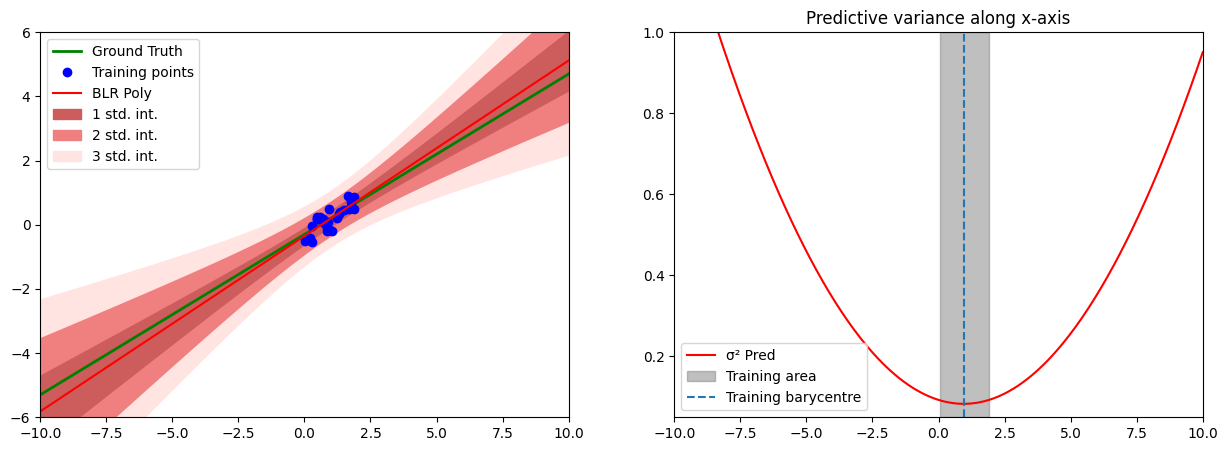

In [ ]:
#@title **[CODING TASK]** Predict on test dataset and visualize results { form-width: "15%" }

# ============ YOUR CODE HERE ============
# Predict test points and use visualization function
# defined at the beginning of the notebook
# You should use the following parameters for plot_results
# xmin=-10, xmax=10, ymin=-6, ymax=6, stdmin=0.05, stdmax=1

# Get the prediction function
f_pred = closed_form(phi_linear, dataset_linear['X_train'], dataset_linear['y_train'],
                     dataset_linear['ALPHA'], dataset_linear['BETA'])

# Predict on test points
y_pred = []
std_pred = []
for x in dataset_linear['X_test']:
    mean, std = f_pred(x)
    y_pred.append(mean)
    std_pred.append(std)

y_pred = np.array(y_pred)
std_pred = np.array(std_pred)

# Visualize results
plot_results(dataset_linear['X_train'], dataset_linear['y_train'],
             dataset_linear['X_test'], dataset_linear['y_test'],
             y_pred, std_pred,
             xmin=-10, xmax=10, ymin=-6, ymax=6, stdmin=0.05, stdmax=1)

# **Question 1.5: Analyse these results. Why predictive variance increases far from training distribution? Prove it analytically in the case where $\alpha=0$ and $\beta=1$.**

## Bayesian Linear Regression – Predictive Variance

### Proof:

In Bayesian Linear Regression, the predictive variance is composed of two terms.

$$
\sigma_N^2(x^*) =
\frac{1}{\beta}
+
\phi(x^*)^\top \Sigma_N \phi(x^*)
$$

The first term is the **noise variance**.  
The second term represents **epistemic uncertainty**, i.e. uncertainty due to lack of data.

When the test point $x^*$ is far from the training data, the basis functions
$\phi(x^*)$ may take large values (for example polynomial terms).
Since $\Sigma_N$ is positive definite, the quadratic form grows, increasing uncertainty.

---

### Analytical Proof (α = 0, β = 1)

We use a linear basis function:

$$
\phi(x) =
\begin{bmatrix}
1 \\
x
\end{bmatrix}
$$

The posterior covariance matrix is:

$$
\Sigma_N = (\Phi^\top \Phi)^{-1}
$$

Let $N$ be the number of samples. The design matrix product is:

$$
\Phi^\top \Phi =
\begin{pmatrix}
N & \sum_i x_i \\
\sum_i x_i & \sum_i x_i^2
\end{pmatrix}
$$

---

### Determinant

$$
D = N \sum_i x_i^2 - \left(\sum_i x_i\right)^2
$$

This can be rewritten as:

$$
D = N \sum_i (x_i - \bar{x})^2 = N S_{xx}
$$

---

### Posterior Covariance

$$
\Sigma_N =
\frac{1}{N S_{xx}}
\begin{pmatrix}
\sum_i x_i^2 & -\sum_i x_i \\
-\sum_i x_i & N
\end{pmatrix}
$$

---

### Model Variance at the Test Point

The model variance at $x^*$ is:

$$
v(x^*) =
\begin{bmatrix}
1 & x^*
\end{bmatrix}
\Sigma_N
\begin{bmatrix}
1 \\
x^*
\end{bmatrix}
$$

Expanding the expression gives:

$$
v(x^*) =
\frac{1}{N S_{xx}}
\left(
\sum_i x_i^2
- 2 x^* \sum_i x_i
+ N (x^*)^2
\right)
$$

Using the identity:

$$
\sum_i x_i^2 = S_{xx} + N \bar{x}^2
$$

we obtain:

$$
v(x^*) =
\frac{1}{N S_{xx}}
\left(
S_{xx} + N (x^* - \bar{x})^2
\right)
$$

This simplifies to:

$$
v(x^*) =
\frac{1}{N}
+
\frac{(x^* - \bar{x})^2}{S_{xx}}
$$

---

### Total Predictive Variance

Finally, the total predictive variance is:

$$
\sigma_N^2(x^*) =
1
+
\frac{1}{N}
+
\frac{(x^* - \bar{x})^2}{S_{xx}}
$$

---

### Key Insight

The predictive variance increases **quadratically** as the test point
moves away from the mean of the training data.
This behavior captures **epistemic uncertainty**.

# **Bonus Question: What happens when applying Bayesian Linear Regression on the following dataset?**

# Answer:

When we apply Bayesian Linear Regression to a dataset with a gap (no data between $x=-1$ and $x=1$):

**Mean Prediction:** The model's mean prediction interpolates linearly across the gap.


**Uncertainty (Predictive Variance):** a significant "bubble" of uncertainty in the missing region.


**Conclusion:** This illustrates the power of Bayesian methods over Frequentist ones. While both can predict a value in the gap, only the Bayesian model tells you that it is uncertain there because it hasn't seen any data.

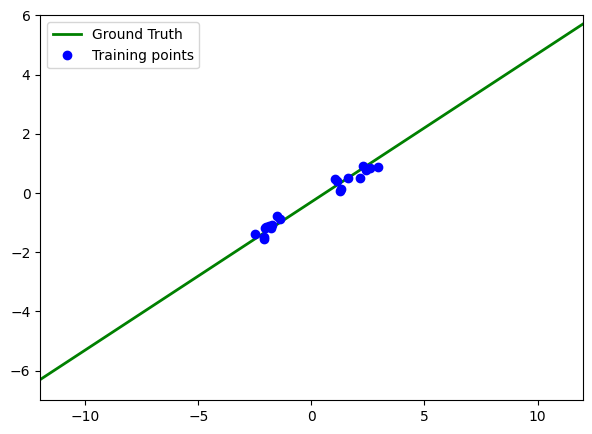

In [ ]:
# Create training and test points
sigma = 0.2
dataset_hole = {}
dataset_hole['X_train'] = np.concatenate(([np.random.uniform(-3, -1, 10), np.random.uniform(1, 3, 10)]), axis=0)
dataset_hole['y_train'] = f_linear(dataset_hole['X_train'], noise_amount=1,sigma=sigma)
dataset_hole['X_test'] = np.linspace(-12,12, 100)
dataset_hole['y_test'] = f_linear(dataset_hole['X_test'], noise_amount=0,sigma=sigma)
dataset_hole['ALPHA'] = 2.0
dataset_hole['BETA'] = 1/(2.0*sigma**2)

# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmin =-12, xmax = 12)
plt.ylim(ymin = -7, ymax = 6)
plt.plot(dataset_hole['X_test'], dataset_hole['y_test'], color='green', linewidth=2, label="Ground Truth")
plt.plot(dataset_hole['X_train'], dataset_hole['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

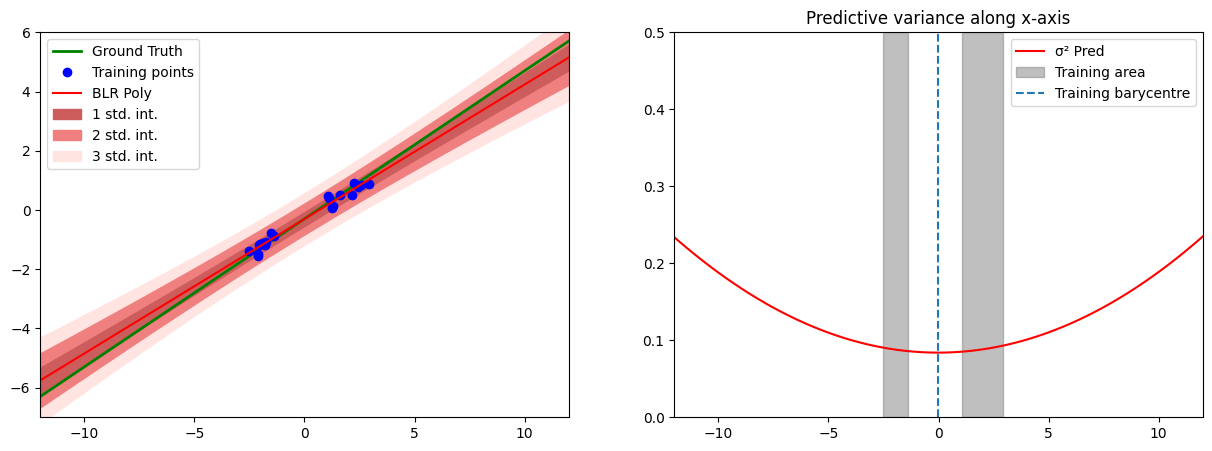

In [ ]:
#@title **[BONUS CODING TASK]** Define f_pred, predict on test points and plot results { form-width: "15%" }
# TO DO: Define f_pred, predict on test points and plot results
f_pred = closed_form(phi_linear, dataset_hole['X_train'], dataset_hole['y_train'],
                     dataset_hole['ALPHA'], dataset_hole['BETA'])
# ============ YOUR CODE HERE ============
# Define new f_pred, then predict test points
# and use visualization function as before
# You should use the following parameters for plot_results
# xmin=-12, xmax=12, ymin=-7, ymax=6, stdmin=0.0, stdmax=0.5

# Predict on test points
y_pred = []
std_pred = []
for x in dataset_hole['X_test']:
    mean, std = f_pred(x)
    y_pred.append(mean)
    std_pred.append(std)

y_pred = np.array(y_pred)
std_pred = np.array(std_pred)

# Visualize results
plot_results(dataset_hole['X_train'], dataset_hole['y_train'],
             dataset_hole['X_test'], dataset_hole['y_test'],
             y_pred, std_pred,
             xmin=-12, xmax=12, ymin=-7, ymax=6, stdmin=0.0, stdmax=0.5)

## Part II: Non Linear models

We now introduce a more complex toy dataset, which is an increasing sinusoidal curve. The goal of this part is to get insight on the importance of the chosen basis function on the predictive variance behavior.

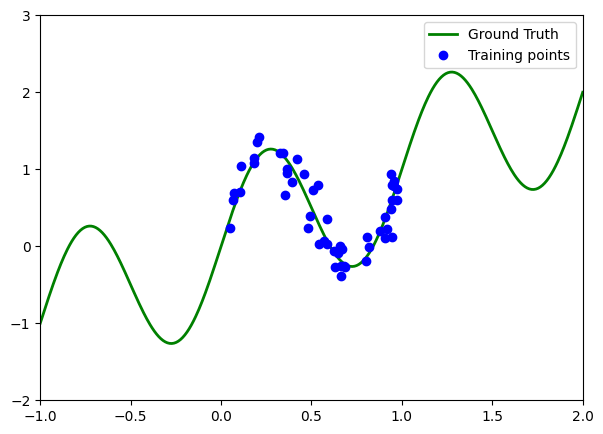

In [ ]:
# Generate sinusoidal toy dataset
def f_sinus(x, noise_amount,sigma=0.2):
    y = np.sin(2*np.pi*x) + x
    noise = np.random.normal(0, sigma, len(x))
    return y + noise_amount * noise

# Create training and test points
sigma=0.2
nbpts=50
dataset_sinus = {}
dataset_sinus['X_train'] = np.random.uniform(0, 1, nbpts)
dataset_sinus['y_train'] = f_sinus(dataset_sinus['X_train'], noise_amount=1,sigma=sigma)
dataset_sinus['X_test'] = np.linspace(-1,2, 10*nbpts)
dataset_sinus['y_test'] = f_sinus(dataset_sinus['X_test'], noise_amount=0,sigma=sigma)

dataset_sinus['ALPHA'] = 0.05
dataset_sinus['BETA'] = 1/(2.0*sigma**2)

# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmin =-1, xmax = 2)
plt.ylim(ymin = -2, ymax = 3)
plt.plot(dataset_sinus['X_test'], dataset_sinus['y_test'], color='green', linewidth=2,
         label="Ground Truth")
plt.plot(dataset_sinus['X_train'], dataset_sinus['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()


### II.1 Polynomial basis functions

We will first use polynomial basis functions:
$$\phi:x \rightarrow (\phi_0,\phi_1,...,\phi_{D-1})$$
where $\phi_j = x^j$ for $j \geq 0$ and $D \geq 0$


Design matrix $\Phi$ defined on training set is:
$$ \Phi=
  \begin{bmatrix}
    1 & x_1 & x_1^2 &... &x_1^{D-1} \\
    ... & ... & ... & ...\\
    1 & x_n & x_n^2 &... &x_n^{D-1}
  \end{bmatrix}
$$

**Question 2.1: Code polynomial basis function**

In [ ]:
def phi_polynomial(x):
    """ Polynomial Basis Functions

    Args:
      x: (float) 1D input

    Returns:
      (array) polynomial features of x
    """
    D = 10
    return np.array([x**j for j in range(D)])

# **Question 2.2 : Code and visualize results on sinusoidal dataset using polynomial basis functions. What can you say about the predictive variance?**

# **Observation:** , the variance explodes, because the model fits the data well within the training range, but as soon as you move outside that range (extrapolation).


# **Why?:** Polynomials are highly sensitive to the input $x$ ($x^D$ grows extremely fast). Without data to constrain the coefficients $w$ in those outer regions, the posterior distribution allows for a wide range of curves that all fit the training data but diverge wildly outside of it.

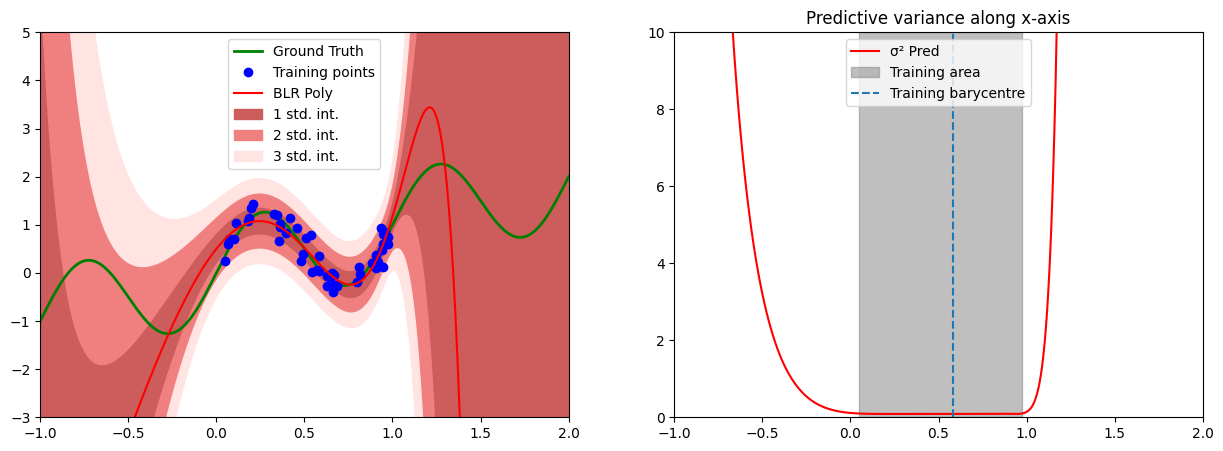

In [ ]:
#@title **[CODING TASK]** Implement closed form for polynomial features and visualise results { form-width: "15%" }

# ============ YOUR CODE HERE ============
# Define f_pred as the closed form for polynomial features
# with a sinusoidal dataset
# Then, predict test points and use visualization function
# defined at the beginning of the notebook
# You should use the following parameters for plot_results
# xmin=-1, xmax=2, ymin=-3, ymax=5, stdmin=0, stdmax=10

f_pred = closed_form(phi_polynomial, dataset_sinus['X_train'], dataset_sinus['y_train'],
                     dataset_sinus['ALPHA'], dataset_sinus['BETA'])

# Predict on test points
y_pred = []
std_pred = []
for x in dataset_sinus['X_test']:
    mean, std = f_pred(x)
    y_pred.append(mean)
    std_pred.append(std)

y_pred = np.array(y_pred)
std_pred = np.array(std_pred)

# Visualize results
plot_results(dataset_sinus['X_train'], dataset_sinus['y_train'],
             dataset_sinus['X_test'], dataset_sinus['y_test'],
             y_pred, std_pred,
             xmin=-1, xmax=2, ymin=-3, ymax=5, stdmin=0, stdmax=10)


### III. Introduction to Bayesian Neural Networks

Moving on to a non-linear classification dataset, we will leverage a Multi-Layer Perceptron (MLP).

Training a neural network with randomly dropping some activations, such as with dropout layers, can actually be seen as an **approximate variational inference method**!

[Gal and Ghahramani, 2016] showed this can be fullfilled for:
- $p(\pmb{w}) = \prod_l p(\pmb{W}_l) = \prod_l \mathcal{N}(0, I/ l_i^2)$ $\Rightarrow$ Multivariate Gaussian distribution factorized over layers
- $q(\pmb{w}) = \prod_l q(\pmb{W}_l) = \prod_l \textrm{diag}(\varepsilon_l)\odot\pmb{M}_l $ with $\varepsilon_l \sim \textrm{Ber}(1-p_l)$.

We will now implement a MLP with dropout layers and perform Monte-Carlo sampling to obtain the predictive distribution $p(\mathbf{y} \vert \pmb{x}^*, \pmb{w})$ for a new sample $\pmb{x}^*$.

In [ ]:
#@title Hyperparameters for model and approximate inference { form-width: "30%" }

NOISE_MOON = 0.05 #@param
WEIGHT_DECAY = 5e-2 #@param
NB_SAMPLES = 100 #@param
TEXT_LOCATION = (-1.5, -1.5)

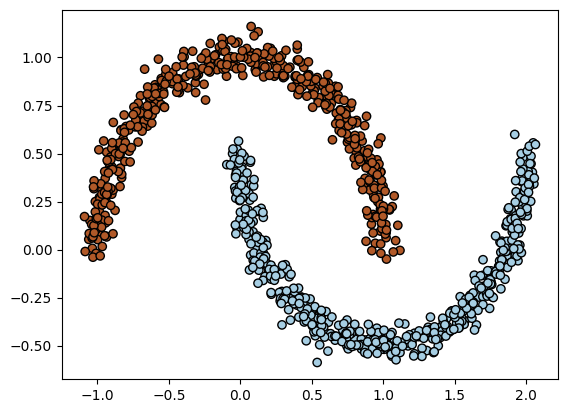

In [ ]:
from sklearn.datasets import make_moons
import torch
import torch.utils.data as data

# Load two moons dataset
X, y = make_moons (n_samples=1000, noise=NOISE_MOON)
X, y = torch.from_numpy(X), torch.from_numpy(y)
X, y = X.type(torch.float), y.type(torch.float)
torch_train_dataset = data.TensorDataset(X,y) # create your datset
train_dataloader = data.DataLoader(torch_train_dataset, batch_size=len(torch_train_dataset))
N_DIM = X.shape[1]

# Visualize dataset
plt.scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
plt.show()

In [ ]:
#@title **[CODING TASK]** Implement a MLP with dropout (p=0.2)
# Code MLP with 1 hidden layer and a dropout layer. Be careful, the dropout
# layer should be also activated during test time.
# (Hint: we may want to look out at F.dropout())
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from sklearn.datasets import make_moons
from IPython import display
class MLP(nn.Module):
    """ Pytorch MLP for binary classification model with an added dropout layer"""
    def __init__(self, input_size, hidden_size):
        super().__init__()
        # ============ YOUR CODE HERE ============
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.dropout_p = 0.2
    def forward(self, x):
        # ============ YOUR CODE HERE ============
        # Don't forget to apply the sigmoid function when returning the output
        x = F.relu(self.fc1(x))
        # Use F.dropout with training=True to keep dropout active during inference
        x = F.dropout(x, p=self.dropout_p, training=True)
        x = torch.sigmoid(self.fc2(x))
        return x

**[CODING TASK]**  Complete the following function to plot the decision boundary and predictive distribution for models sampled with MC dropout.

In [ ]:
def plot_decision_boundary(model, X, Y, epoch, accuracy, model_type='classic',
                           nsamples=100, posterior=None, tloc=(-4,-7),
                           nbh=2, cmap='RdBu'):
    """ Plot and show learning process in classification """
    h = 0.02*nbh
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min*2, x_max*2, h),
                         np.arange(y_min*2, y_max*2, h))

    test_tensor = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.FloatTensor)
    model.eval()
    with torch.no_grad():
      if model_type=='classic':
          pred = model(test_tensor)
      elif model_type=='mcdropout':
         # ============ YOUR CODE HERE ============
         # Compute the MC estimate of the predictive distribution
         # Don't forget to keep the dropout activated
        predictions = []
        for _ in range(nsamples):
              # model still uses F.dropout with training=True, so dropout is active
            pred_sample = model(test_tensor)
            predictions.append(pred_sample)
          # Stack and compute mean
        predictions = torch.stack(predictions, dim=0)  # Shape: (nsamples, N, 1)
        pred = predictions.mean(dim=0)  # Shape: (N, 1)

    Z = pred.reshape(xx.shape).detach().numpy()

    plt.cla()
    ax.set_title('Classification Analysis')
    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.25)
    ax.contour(xx, yy, Z, colors='k', linestyles=':', linewidths=0.7)
    ax.scatter(X[:,0], X[:,1], c=Y, cmap='Paired_r', edgecolors='k');
    ax.text(tloc[0], tloc[1], f'Epoch = {epoch+1}, Accuracy = {accuracy:.2%}', fontdict={'size': 12, 'fontweight': 'bold'})
    display.display(plt.gcf())
    display.clear_output(wait=True)

We train our model as usual:

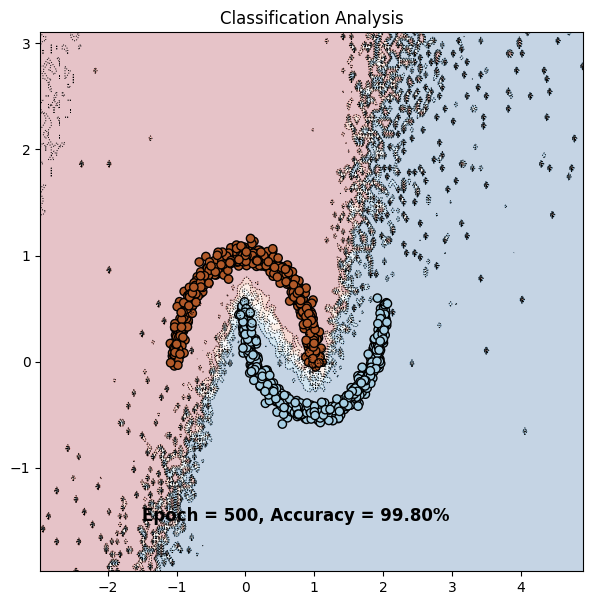

In [ ]:
net = MLP(input_size=X.shape[1], hidden_size=50)
net.train()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
fig, ax = plt.subplots(figsize=(7,7))

for epoch in range(500):  # loop over the dataset multiple times

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    output = net(X).squeeze()
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()

    # For plotting and showing learning process at each epoch, uncomment and indent line below
    if (epoch+1)%50==0:
      plot_decision_boundary(net, X, y, epoch, ((output.squeeze()>=0.5) == y).float().mean(), tloc=TEXT_LOCATION, model_type='classic')


Now let's look at the results given by MC Dropout:

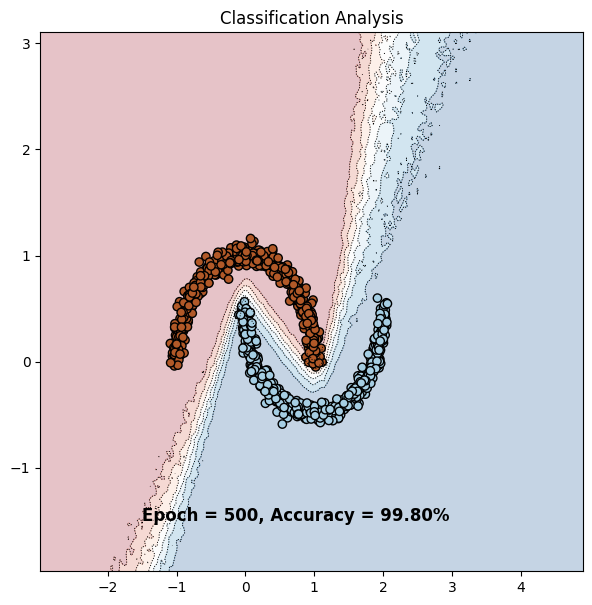

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
plot_decision_boundary(net, X, y, epoch, ((output.squeeze()>=0.5) == y).float().mean(), tloc=TEXT_LOCATION, model_type='mcdropout')

# 4. Bayesian Neural Networks (MLP with Dropout) Monte Carlo Dropout:

By keeping Dropout active at test time, we are essentially sampling different "thinned" networks.


**Predictive Distribution:** The mean of multiple forward passes gives the predictive mean, and the variance across those passes gives the model's uncertainty.


**Decision Boundary:** In the classification task, the decision boundary is no longer a sharp line. Instead, we see a transition zone where the model's confidence (the mean probability) is around 0.5 and the standard deviation is high. This correctly identifies the "ambiguous" areas between classes.

# **General Summary**

## **Bayesian Linear Regression: Problem, Context, and Approach**

This practical focuses on **Bayesian Linear Regression**, moving from standard point-estimate regression to a **probabilistic approach** that explicitly quantifies uncertainty in predictions.

Below is a structured summary of the problem, context, and approach, organized to highlight the learning objectives.

---

## **1. General Problem and Context**

The core problem is **regression in a Bayesian framework**.  
Unlike standard linear regression, which fits a function by minimizing an error metric, this practical formulates regression probabilistically.

**Goal:**  
Instead of finding a single optimal set of weights $\mathbf{w}$, we aim to compute the **posterior distribution** over the weights given the observed data.

**Motivation:**  
This allows the model to express **predictive uncertainty**. Rather than outputting only a point prediction, the model also quantifies how confident it is. In the notebook, this is visualized through **predictive variance** or **error bars**, which increase in regions with little or no data.

---

## **2. The Approach**

The practical follows a progressive complexity strategy, applying the same Bayesian framework to different representations of the input data using **basis functions**.

### **A. The Foundation: Linear Basis**

- **Data:** Simple linear toy dataset  
- **Basis Function:**  
  $$ \phi(x) = (1, x) $$
- **Bayesian Step:**  
  The posterior distribution is computed analytically, leveraging the conjugacy between Gaussian priors and Gaussian likelihoods.
- **Insight:**  
  Sampling from the posterior corresponds to drawing multiple plausible regression lines that are consistent with the observed data.

---

### **B. Increasing Complexity: Non-Linear Data**

- **Data:** Sinusoidal (non-linear) dataset  
- **Challenge:**  
  A linear model cannot capture non-linear structure.
- **Polynomial Basis:**  
  The input is mapped to:
  $$ [1, x, x^2, \dots, x^D] $$
  enabling the model to represent curved functions.
- **Observation:**  
  Higher-degree polynomials fit the data better but introduce the risk of overfitting. Bayesian priors naturally regularize this behavior.

---

### **C. Localized Representations: Gaussian Basis**

- **Method:**  
  The input is mapped to a set of Gaussian basis functions distributed across the input domain.
- **Key Property:**  
  Each Gaussian kernel acts locally, and its amplitude corresponds to a learned weight.
- **Insight:**  
  This demonstrates how **Radial Basis Function (RBF)** models operate in a Bayesian setting, allowing flexible and localized function approximation.

---

## **3. Personal Understanding and Takeaways**

A central takeaway from this practical is the relationship between **model complexity and uncertainty**.

### **Uncertainty Is Dynamic**

The predictive variance is low near training points and increases significantly in regions without data. This behavior highlights a key safety feature of Bayesian models that standard deterministic models lack.

### **Role of Hyperparameters $\alpha$ and $\beta$**

The practical illustrates the interaction between:
- **Prior precision ($\alpha$)**, controlling model complexity.
- **Noise precision ($\beta$)**, governing data noise.

Their balance determines how strongly the model trusts prior assumptions versus observed data.

### **Analytical Elegance**

Unlike modern deep learning approaches that rely on approximate inference methods (e.g., Monte Carlo Dropout), this practical uses **closed-form solutions**. The exact posterior mean and covariance can be computed analytically, providing a clear and rigorous understanding of Bayesian learning principles.

---

## **Summary & Conclusion**

**Good:**
- Explicit uncertainty quantification  
- Closed-form posterior solutions  
- Clear interpretation of model confidence  
- Natural regularization through priors  

**Bad:**
- Limited scalability to very high-dimensional or large-scale problems  
- Requires strong distributional assumptions (Gaussian priors and likelihoods)